**Deep Learning AA 2022/2023**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (antonio.purificato@uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli@diag.uniroma1.it) \

We need to install (Hugging Face) 🤗 Transformers and 🤗 Datasets.

In [ ]:
%%capture
! pip install "datasets" "transformers" "pytorch-lightning" "wandb"

In [ ]:
import datasets
import torch
import wandb
import numpy as np
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from datasets import load_dataset, load_metric
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertModel,
    pipeline
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

AVAIL_GPUS = min(1, torch.cuda.device_count())

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
wandb.login(key = '88987d90526e97d3144c1c3c7ff85ae9b3ea37ad')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Hugging Face Transformers
The [Hugging Face Transformers](https://huggingface.co/transformers/#) package provides State-of-the-art architectures for Natural Language Processing for Jax, Pytorch and TensorFlow. They host pre-trained models operating in over 100 languages that you can use right out of the box.


More reference here [🤗 Quickstart guide](https://huggingface.co/transformers/quicktour.html) and here [Transformer Notebooks](https://huggingface.co/transformers/notebooks.html)

**Textual entailment** in natural language processing is a directional relation between text fragments.
The Recognizing Textual Entailment (RTE) task is defined as recognizing, given two text fragments, whether the meaning of one text can be inferred (entailed) from the other.
In the TE framework, the entailing and entailed texts are termed text (t) and hypothesis (h), respectively.

## Using a Transformer model for Sentence Inference

To train a Transformer for Natural Language Inference (NLI) (also known as Recognizing Textual Entailment, RTE) we'll need
1. to choose a NLI dataset
2. to pick a specific model architecture,
3. to finetune the model.



### 1. NLI or RTE dataset: RTE

Given two text fragments called ‘Text’ and ‘Hypothesis’, Textual Entailment Recognition is the task of determining whether the meaning of the Hypothesis is entailed (can be inferred) from the Text.



The Recognizing Textual Entailment (RTE) datasets come from a series of annual textual entailment challenges. Examples are constructed based on news and Wikipedia text.


Here are a few example pairs taken from the training portion of the corpus.


| Text  | Hypothesis | Entailment|
| --- | --- | --- |
|No Weapons of Mass Destruction Found in Iraq Yet.| Weapons of Mass Destruction Found in Iraq.|not_entailment|
|A place of sorrow, after Pope John Paul II died, <br /> became a place of celebration, as Roman <br /> Catholic   faithful gathered in downtown Chicago <br /> to mark  the installation of new Pope Benedict XVI.| Pope Benedict XVI is the new leader <br />of the Roman Catholic Church.| entailment|
|Herceptin was already approved to treat the <br /> sickest breast cancer patients, and the company <br /> said, Monday, it will discuss with federal regulators <br /> the possibility of prescribing the drug for more<br /> breast cancer patients.| Herceptin can be used to treat breast cancer.| entailment
|Judie Vivian, chief executive at ProMedica, a <br /> medical service company that helps sustain the <br /> 2-year-old Vietnam Heart Institute in Ho Chi Minh <br /> City (formerly Saigon), said that so far about <br /> 1,500 children have received treatment.| The previous name of Ho Chi Minh City was Saigon.| entailment
|Oil prices fall back as Yukos oil threat lifted| Oil prices rise.|not_entailment
|Cyprus, divided or not, joins the EU on the 1st of May.| Cyprus was divided into two parts on May 1.| not_entailment


### 2. Pick a Model

in this notebook we'll use the classic BERT model, feel free to try out some others.
[List of Hugging Face modules]( https://huggingface.co/transformers/pretrained_models.html)

# Loading the Dataset

We will use the 🤗 Datasets library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric.

We can directly pass our task name to those functions. load_dataset will cache the dataset to avoid downloading it again the next time you run this cell.

In [ ]:
%%capture
task = "rte"
dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set. We use the [Glue datasets](https://huggingface.co/datasets/glue)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
dataset["train"][0]

{'sentence1': 'No Weapons of Mass Destruction Found in Iraq Yet.',
 'sentence2': 'Weapons of Mass Destruction Found in Iraq.',
 'label': 1,
 'idx': 0}


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [ ]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

You can call its compute method with your predictions and labels directly and it will return a dictionary with the metric(s) value. In this case it only returns accuracy. Let's see an example

`load_metric` has loaded the proper metric associated to our task, which is:
- for RTE: Accuracy

Examples for other tasks:
- for CoLA: [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)
- for MNLI (matched or mismatched): Accuracy
- for MRPC: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for QNLI: Accuracy- for QQP: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for STS-B: [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman's_Rank_Correlation_Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- for WNLI: Accuracy.
- for SST-2: Accuracy

In [ ]:
fake_preds = np.random.randint(0, 2, size=(5,)) # predictions (here chosen randomly)
fake_labels = np.random.randint(0, 2, size=(5,)) # real labels (here these are random as well)
print(fake_preds, fake_labels)
metric.compute(predictions=fake_preds, references=fake_labels)

[0 0 1 1 0] [0 1 1 0 1]


{'accuracy': 0.4}

# Preprocessing the data


Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires. To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:
- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

Note that vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
model_checkpoint = "bert-base-uncased"
batch_size = 16

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. If you're interested you can learn more about them [here](https://huggingface.co/transformers/preprocessing.html).

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

# Training BERT with Lightning

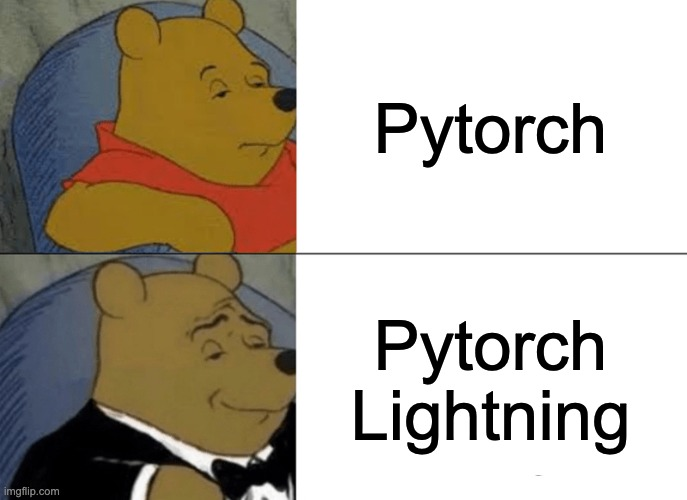

### Lightning DataModule

In [ ]:
class RTEDataModule(LightningDataModule):

    loader_columns = [
        "datasets_idx",
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "start_positions",
        "end_positions",
        "labels",
    ]

    def __init__(
        self,
        model_name_or_path: str,
        task_name: str = "rte",
        max_seq_length: int = 128,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.model_name_or_path = model_name_or_path
        self.task_name = task_name
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size

        self.text_fields = ["sentence1", "sentence2"]
        self.num_labels = 2
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def setup(self, stage: str):
        self.dataset = datasets.load_dataset("glue", self.task_name)

        for split in self.dataset.keys():
            self.dataset[split] = self.dataset[split].map(
                self.convert_to_features,
                batched=True,
                remove_columns=["label"],
            )
            self.columns = [c for c in self.dataset[split].column_names if c in self.loader_columns]
            self.dataset[split].set_format(type="torch", columns=self.columns)

        self.eval_splits = [x for x in self.dataset.keys() if "validation" in x]

    def prepare_data(self):
        datasets.load_dataset("glue", self.task_name)
        AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def train_dataloader(self):
        return DataLoader(self.dataset["train"], batch_size=self.train_batch_size)

    def val_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["validation"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def test_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["test"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def convert_to_features(self, example_batch, indices=None):

        # Encode sentence pairs
        texts_or_text_pairs = list(zip(example_batch[self.text_fields[0]], example_batch[self.text_fields[1]]))

        # Tokenize the text pairs
        features = self.tokenizer.batch_encode_plus(texts_or_text_pairs, max_length=self.max_seq_length, pad_to_max_length=True, truncation=True)

        # Rename label to labels to make it easier to pass to model forward
        features["labels"] = example_batch["label"]

        return features

In [ ]:
dm = RTEDataModule("bert-base-uncased")
dm.prepare_data()
dm.setup("fit")
ex= next(iter(dm.train_dataloader()))
print(ex)

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'input_ids': tensor([[  101,  2053,  4255,  ...,     0,     0,     0],
        [  101,  1037,  2173,  ...,     0,     0,     0],
        [  101,  2014,  3401,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  4273,  ...,     0,     0,     0],
        [  101,  2028,  3171,  ...,     0,     0,     0],
        [  101, 19254,  2031,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0])}


### Transformer LightningModule

In [ ]:
class RTETransformer(LightningModule):
    def __init__(
        self,
        num_labels: int,
        task_name: str,
        model_name_or_path: str="bert-base-uncased",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        #warmup_steps: int = 0,
        weight_decay: float = 0.0,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.config = AutoConfig.from_pretrained(model_name_or_path, num_labels=2)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=self.config)
        self.metric = datasets.load_metric("glue", "rte" )
        for name, param in self.named_parameters():
          if "classifier" not in name :
            param.requires_grad= False


    def forward(self, **inputs):
        return  self.model (**inputs)

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self(**batch)
        preds = outputs.logits
        self.log('train_loss',outputs.loss, on_step=False, on_epoch=True)
        predictions = torch.argmax(preds, axis=1)
        acc = self.metric.compute(predictions= predictions,references=labels)
        self.log('train_acc', acc['accuracy'], on_step=False, on_epoch=True)
        outputs = {"loss": outputs.loss, "acc": acc}
        return outputs

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        val_loss = outputs.loss
        logits = outputs.logits
        self.log('val_loss', val_loss, on_step=False, on_epoch=True)
        predictions = torch.argmax(logits, axis=1)
        labels = batch["labels"]
        acc = self.metric.compute(predictions= predictions,references=labels)
        self.log('val_acc', acc['accuracy'], on_step=False, on_epoch=True)
        return {"loss": outputs.loss, "acc": acc}

    def configure_optimizers(self):
        #model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return [optimizer]


# The thousand faces of transformers

In the following, the pretrained BERT model bert is fed into the BERTClassifier instance net for the downstream application. In common implementations of BERT fine-tuning, only the parameters of the output layer of the additional MLP (net.output) will be learned from scratch. All the parameters of the pretrained BERT encoder (net.encoder) and the hidden layer of the additional MLP (net.hidden) will be fine-tuned.

In [ ]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Today it's raining so I have to [MASK] an umbrella.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.29034870862960815,
  'token': 4929,
  'token_str': 'wear',
  'sequence': "today it's raining so i have to wear an umbrella."},
 {'score': 0.23668299615383148,
  'token': 2224,
  'token_str': 'use',
  'sequence': "today it's raining so i have to use an umbrella."},
 {'score': 0.07622408121824265,
  'token': 9278,
  'token_str': 'rent',
  'sequence': "today it's raining so i have to rent an umbrella."},
 {'score': 0.05764966085553169,
  'token': 4965,
  'token_str': 'buy',
  'sequence': "today it's raining so i have to buy an umbrella."},
 {'score': 0.05578221008181572,
  'token': 3288,
  'token_str': 'bring',
  'sequence': "today it's raining so i have to bring an umbrella."}]

## Training

In [ ]:
seed_everything(42)

dm = RTEDataModule(model_name_or_path="bert-base-uncased", task_name="rte")

#dm.setup("fit")
model = RTETransformer(
    model_name_or_path="bert-base-uncased",
    num_labels=dm.num_labels,
    #eval_splits=dm.eval_splits,
    task_name=dm.task_name,
)


INFO:lightning_fabric.utilities.seed:Seed set to 42
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 10
wandb.init(project= "Transformers for time series prediction",
      name= "PROVA2", #model.hparams.task_name,
      config={
      "learning_rate": model.hparams.learning_rate,
      "dataset": "GLUE",
      "epochs": 2,
      "train batch size" : model.hparams.train_batch_size,
      "eval batch size" : model.hparams.eval_batch_size
      })

wandb: Currently logged in as: antoniopurificato. Use `wandb login --relogin` to force relogin


In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad, )

model.bert.embeddings.word_embeddings.weight False
model.bert.embeddings.position_embeddings.weight False
model.bert.embeddings.token_type_embeddings.weight False
model.bert.embeddings.LayerNorm.weight False
model.bert.embeddings.LayerNorm.bias False
model.bert.encoder.layer.0.attention.self.query.weight False
model.bert.encoder.layer.0.attention.self.query.bias False
model.bert.encoder.layer.0.attention.self.key.weight False
model.bert.encoder.layer.0.attention.self.key.bias False
model.bert.encoder.layer.0.attention.self.value.weight False
model.bert.encoder.layer.0.attention.self.value.bias False
model.bert.encoder.layer.0.attention.output.dense.weight False
model.bert.encoder.layer.0.attention.output.dense.bias False
model.bert.encoder.layer.0.attention.output.LayerNorm.weight False
model.bert.encoder.layer.0.attention.output.LayerNorm.bias False
model.bert.encoder.layer.0.intermediate.dense.weight False
model.bert.encoder.layer.0.intermediate.dense.bias False
model.bert.encoder.la

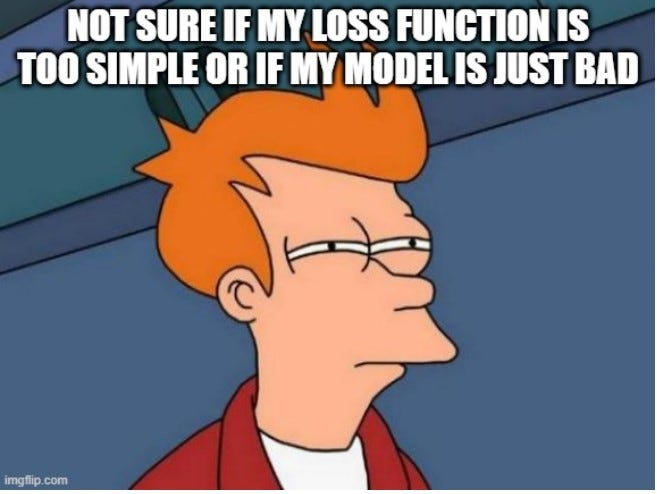

In [ ]:
wandb_logger = WandbLogger(log_model="all")
trainer = Trainer(max_epochs=EPOCHS, accelerator="auto", logger=wandb_logger)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M 
--------------------------------------------------------
1.5 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,█▇▄▁▅▃▅▄▆█
train_loss,▃▄▂█▃▅▃▄▁▄
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▂▁▂▃▄▄▇▆▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,9
train_acc,0.51687
train_loss,0.70015
trainer/global_step,779
val_acc,0.54874
